# **Bayesian optimization to find optimal criticality from DMRG simulation**
Feb, 2024

-- Notebook prepared by **Arpan Biswas**





In [2]:
!pip install -q git+https://github.com/ziatdinovmax/gpax.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()  # enable double precision

from typing import Union, Dict, Callable

import math

import jax.numpy as jnp
from jax import jit
from gpax.kernels import RBFKernel, MaternKernel

import jax
import numpyro
import random
import scipy.stats as stats

#BO_DMRG

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
from os import ftruncate
import pandas as pd

DMRG_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/MERSEC_Adrian/DMRG_data_new.csv')
DMRG_data

,U,F,F_error
0,3.100,6.150000e-05,1.200000e-06
1,3.200,1.030000e-05,7.220000e-07
2,3.225,3.860000e-06,2.820000e-07
3,3.270,4.640000e-08,6.890000e-08
4,3.275,9.530000e-11,3.210000e-09
5,3.280,2.670000e-08,3.720000e-08
6,3.300,9.340000e-07,2.540000e-07
7,3.346,7.380000e-06,1.020000e-06
8,3.400,2.210000e-05,3.440000e-06
9,NaN,1.180000e-05,7.810000e-07


In [6]:
DMRG_data = DMRG_data.to_numpy()
DMRG_data = DMRG_data[0:-2, :]
DMRG_data[:, 1:3] = (DMRG_data[:, 1:3])*10**5
DMRG_data

array([[3.100e+00, 6.150e+00, 1.200e-01],
       [3.200e+00, 1.030e+00, 7.220e-02],
       [3.225e+00, 3.860e-01, 2.820e-02],
       [3.270e+00, 4.640e-03, 6.890e-03],
       [3.275e+00, 9.530e-06, 3.210e-04],
       [3.280e+00, 2.670e-03, 3.720e-03],
       [3.300e+00, 9.340e-02, 2.540e-02],
       [3.346e+00, 7.380e-01, 1.020e-01],
       [3.400e+00, 2.210e+00, 3.440e-01]])

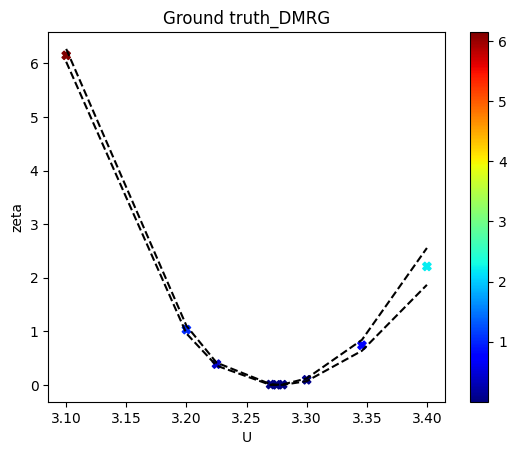

In [7]:

a = plt.scatter(DMRG_data[:, 0], DMRG_data[:, 1], c=DMRG_data[:, 1], cmap="jet", marker="X")
plt.colorbar(a, orientation="vertical")
plt.plot(DMRG_data[:, 0], DMRG_data[:, 1]+DMRG_data[:, 2], "k--")
plt.plot(DMRG_data[:, 0], DMRG_data[:, 1]-DMRG_data[:, 2], "k--")
#plt.legend(loc="best")
#plt.xlim(3.125, 4)
plt.xlabel("U")
plt.ylabel("zeta")
plt.title("Ground truth_DMRG")

plt.show()

In [8]:
lb = 3.2
ub = 3.35

bounds = np.array((lb, ub), dtype=float)
fidelities = np.array((1, 2))
x = np.linspace(lb, ub, 601)
x

array([3.2    , 3.20025, 3.2005 , 3.20075, 3.201  , 3.20125, 3.2015 ,
       3.20175, 3.202  , 3.20225, 3.2025 , 3.20275, 3.203  , 3.20325,
       3.2035 , 3.20375, 3.204  , 3.20425, 3.2045 , 3.20475, 3.205  ,
       3.20525, 3.2055 , 3.20575, 3.206  , 3.20625, 3.2065 , 3.20675,
       3.207  , 3.20725, 3.2075 , 3.20775, 3.208  , 3.20825, 3.2085 ,
       3.20875, 3.209  , 3.20925, 3.2095 , 3.20975, 3.21   , 3.21025,
       3.2105 , 3.21075, 3.211  , 3.21125, 3.2115 , 3.21175, 3.212  ,
       3.21225, 3.2125 , 3.21275, 3.213  , 3.21325, 3.2135 , 3.21375,
       3.214  , 3.21425, 3.2145 , 3.21475, 3.215  , 3.21525, 3.2155 ,
       3.21575, 3.216  , 3.21625, 3.2165 , 3.21675, 3.217  , 3.21725,
       3.2175 , 3.21775, 3.218  , 3.21825, 3.2185 , 3.21875, 3.219  ,
       3.21925, 3.2195 , 3.21975, 3.22   , 3.22025, 3.2205 , 3.22075,
       3.221  , 3.22125, 3.2215 , 3.22175, 3.222  , 3.22225, 3.2225 ,
       3.22275, 3.223  , 3.22325, 3.2235 , 3.22375, 3.224  , 3.22425,
       3.2245 , 3.22

In [9]:
X_test =x

In [10]:
idx =[] # This is where you will save the index number from test data which has been evaluated, so we discard from the BO to consider for re-evaluation
for i in range(0, DMRG_data.shape[0]):
    id = np.argwhere(X_test==DMRG_data[i, 0])
    idx = np.append(idx, id)
idx  = idx.astype(int)
idx

array([  0, 100, 280, 584])

In [11]:
def kernel_prior() -> Dict[str, jnp.ndarray]:
    length = numpyro.sample("k_length", numpyro.distributions.HalfNormal(1))
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    return {"k_length": length, "k_scale": scale}


# Lets remove the left and right extreme samples which has most error to avoid the large model error near the optimal region where the simulation error is much lesser.
# Also lets remove the best sample at $U=3.275$

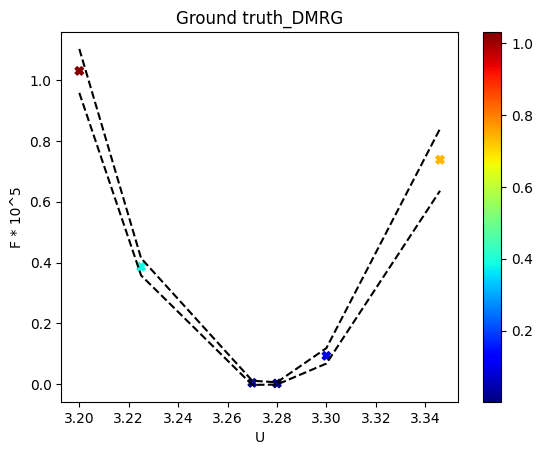

In [12]:
DMRG_data_short = DMRG_data[[1, 2, 3, -4, -3,-2], :]
a = plt.scatter(DMRG_data_short[:, 0], DMRG_data_short[:, 1], c=DMRG_data_short[:, 1], cmap="jet", marker="X")
plt.colorbar(a, orientation="vertical")
plt.plot(DMRG_data_short[:, 0], DMRG_data_short[:, 1]+DMRG_data_short[:, 2], "k--")
plt.plot(DMRG_data_short[:, 0], DMRG_data_short[:, 1]-DMRG_data_short[:, 2], "k--")
#plt.legend(loc="best")
#plt.xlim(3.125, 4)
plt.xlabel("U")
plt.ylabel("F * 10^5")
plt.title("Ground truth_DMRG")

plt.show()

In [13]:
np.mean(DMRG_data_short[:, 2]), np.std(DMRG_data_short[:, 2])

(0.039735, 0.035696239647895686)

In [14]:
idx =[] # This is where you will save the index number from test data which has been evaluated, so we discard from the BO to consider for re-evaluation
for i in range(0, DMRG_data_short.shape[0]):
    id = np.argwhere(X_test==DMRG_data_short[i, 0])
    idx = np.append(idx, id)
idx  = idx.astype(int)
idx

array([  0, 100, 280, 584])

/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:01<00:00, 526.99it/s, 3 steps of size 4.26e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.08      0.03      0.08      0.02      0.13    159.01      1.00
   k_scale      1.90      2.12      1.30      0.15      3.71    171.36      1.01
     noise      0.02      0.02      0.01      0.00      0.04    120.45      1.01



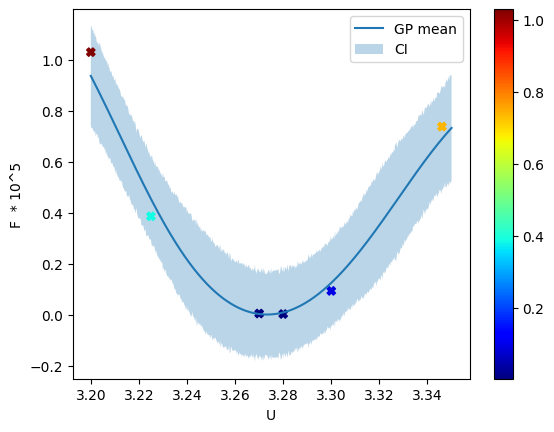

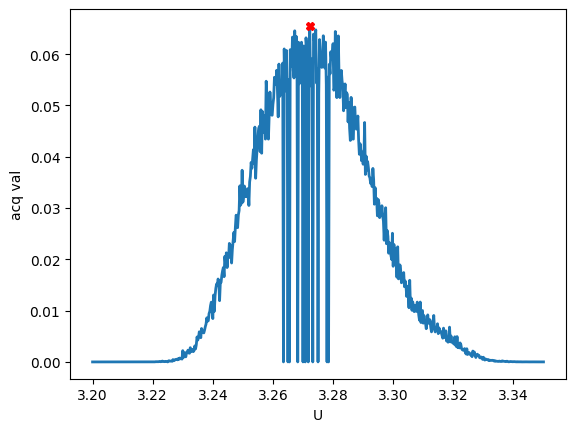

Next point: 3.27225


In [40]:

train_x = DMRG_data_short[:, 0]
train_y = DMRG_data_short[:, 1]

train_y_norm = (train_y - np.min(train_y))/(np.max(train_y) - np.min(train_y))


# Get random number generator keys for training and prediction
#random.seed(1)
rng_key, rng_key_predict = gpax.utils.get_keys(0)


# Initialize MF model
gp_model = gpax.ExactGP(1, kernel='RBF',kernel_prior=kernel_prior, noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.03)))

# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(rng_key, train_x, train_y, num_warmup=500, num_samples=500, num_chains=1)


y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, noiseless=False)

pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
plt.plot(X_test, y_pred, label="GP mean")
plt.fill_between(
    X_test.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
a = plt.scatter(train_x, train_y, c=train_y, cmap="jet", marker="X")
plt.colorbar(a, orientation="vertical")
#plt.xlim(0, 50)
plt.legend(loc="best")
plt.xlabel("U")
plt.ylabel("F  * 10^5")
plt.show()

# Compute the EI acq function
acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=False, noiseless=False)
acq = np.array(acq)
acq[idx] = 0
next_point_val = acq.max()
next_point_idx = acq.argmax()
idx = np.hstack((idx, next_point_idx))

#Plot acquistion function
plt.plot(X_test, acq, linewidth=2)
plt.plot(X_test[next_point_idx], acq[next_point_idx], c="r", marker="X")
plt.xlabel("U")
plt.ylabel("acq val")
plt.show()

if next_point_val == 0:
    print("Model sufficiently learned")
else:
    print("Next point: "+str(X_test[next_point_idx]))




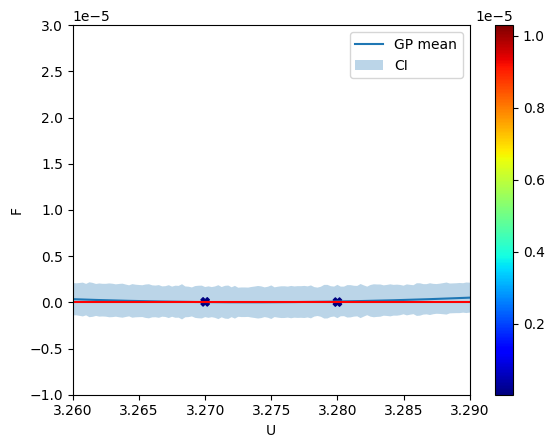

In [41]:
pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
pred_lower = pred_lower/10**5
pred_upper = pred_upper/10**5
plt.plot(X_test, y_pred/10**5, label="GP mean")
plt.fill_between(
    X_test.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
a = plt.scatter(train_x, train_y/10**5, c=train_y/10**5, cmap="jet", marker="X")
plt.colorbar(a, orientation="vertical")
plt.xlim(3.26, 3.29)
plt.ylim(-1/10**5, 3/10**5)
plt.legend(loc="best")
plt.xlabel("U")
plt.ylabel("F")

plt.axhline(y=0, color='r', linestyle='-')
plt.show()


# Structured GP

Prior Model

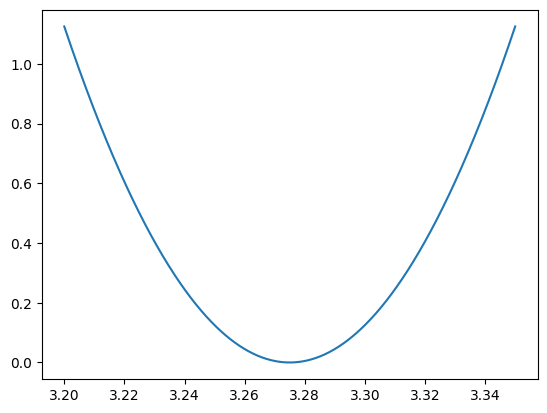

In [37]:
a = 200
h=3.275
k=1e-5
y_test = np.zeros(len(X_test))
y_test = (a*(X_test-h)**2) + k
plt.plot(X_test, y_test, label="True function")

In [19]:
# Defining the probabilistic model
@jit
def mean_func(x, params):

    x_data = x[:,0]

    f = params["a"]*jnp.square(x_data-params["b"]) + params["c"]


    return  f


def mf_priors():
    a = numpyro.sample("a", numpyro.distributions.HalfNormal(1)) #Should be positive for U shape
    b = numpyro.sample("b", numpyro.distributions.Uniform(3.26, 3.29)) #Location of minimal point at X axis
    c = numpyro.sample("c", numpyro.distributions.LogNormal(0,1)) # Y value at minimal point
    return {"a": a, "b": b, "c": c}

/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:02<00:00, 403.38it/s, 7 steps of size 3.30e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.80      0.59      0.68      0.01      1.61    417.49      1.00
         b      3.27      0.01      3.27      3.26      3.29    351.29      1.00
         c      0.98      0.61      0.85      0.18      1.84    377.35      1.01
  k_length      0.08      0.03      0.08      0.03      0.13    278.59      1.00
   k_scale      1.43      1.37      0.98      0.09      3.13    334.43      1.00
     noise      0.02      0.01      0.01      0.00      0.04    442.42      1.00



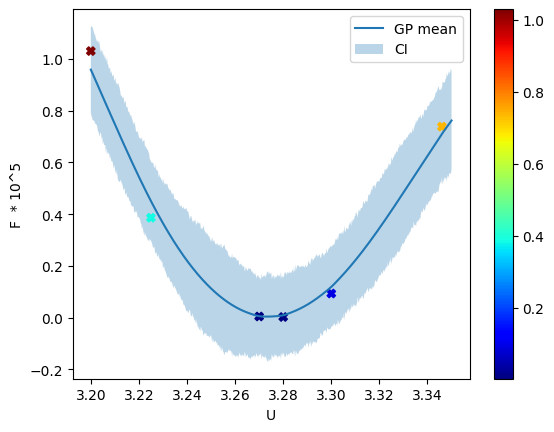

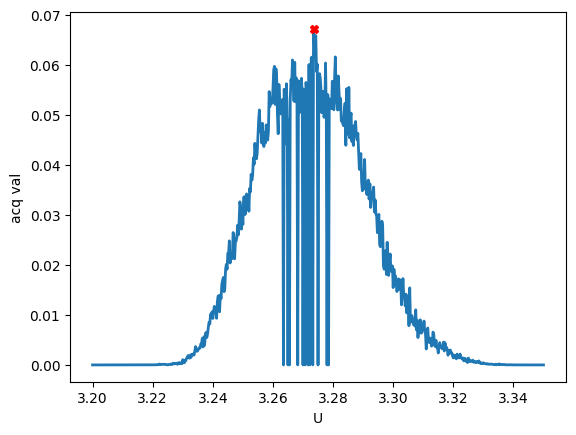

Next point: 3.2735000000000003


In [42]:

train_x = DMRG_data_short[:, 0]
train_y = DMRG_data_short[:, 1]

train_y_norm = (train_y - np.min(train_y))/(np.max(train_y) - np.min(train_y))


# Get random number generator keys for training and prediction
#random.seed(1)
rng_key, rng_key_predict = gpax.utils.get_keys(0)


# Initialize MF model
gp_model = gpax.ExactGP(1, kernel='RBF',kernel_prior=kernel_prior, mean_fn=mean_func, mean_fn_prior=mf_priors,
                        noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(0.03)))

# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(rng_key, train_x, train_y, num_warmup=500, num_samples=500, num_chains=1)


y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, noiseless=False)


pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
plt.plot(X_test, y_pred, label="GP mean")
plt.fill_between(
    X_test.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
a = plt.scatter(train_x, train_y, c=train_y, cmap="jet", marker="X")
plt.colorbar(a, orientation="vertical")
#plt.xlim(0, 50)
plt.legend(loc="best")
plt.xlabel("U")
plt.ylabel("F  * 10^5")
plt.show()

# Compute the EI acq function
acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=False, noiseless=False)
acq = np.array(acq)
acq[idx] = 0
next_point_val = acq.max()
next_point_idx = acq.argmax()
idx = np.hstack((idx, next_point_idx))

#Plot acquistion function
plt.plot(X_test, acq, linewidth=2)
plt.plot(X_test[next_point_idx], acq[next_point_idx], c="r", marker="X")
plt.xlabel("U")
plt.ylabel("acq val")
plt.show()

if next_point_val == 0:
    print("Model sufficiently learned")
else:
    print("Next point: "+str(X_test[next_point_idx]))




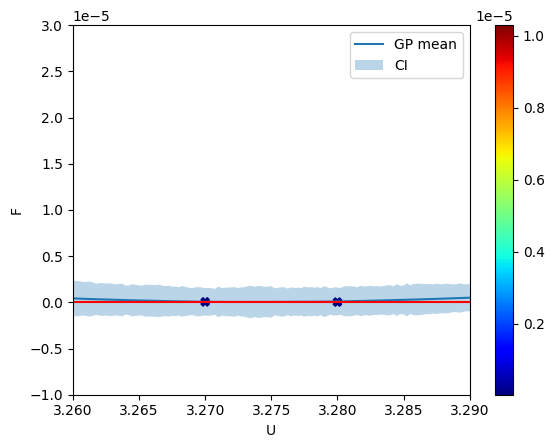

In [43]:
pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
pred_lower = pred_lower/10**5
pred_upper = pred_upper/10**5
plt.plot(X_test, y_pred/10**5, label="GP mean")
plt.fill_between(
    X_test.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
a = plt.scatter(train_x, train_y/10**5, c=train_y/10**5, cmap="jet", marker="X")
plt.colorbar(a, orientation="vertical")
plt.xlim(3.26, 3.29)
plt.ylim(-1/10**5, 3/10**5)
plt.legend(loc="best")
plt.xlabel("U")
plt.ylabel("F")

plt.axhline(y=0, color='r', linestyle='-')
plt.show()


In [44]:
np.min(y_pred),np.argmin(y_pred),np.min(y_sampled.std(axis=(0,1))),np.max(y_sampled.std(axis=(0,1)))

(Array(0.00422158, dtype=float64),
 Array(293, dtype=int64),
 Array(0.14045058, dtype=float64),
 Array(0.21417004, dtype=float64))

In [45]:
X_test[np.argmin(y_pred)]

3.27325

In [ ]:
X_test.shape, y_pred.shape, y_sampled.std(axis=(0,1)).shape
GP_Data = np.vstack((X_test, y_pred, y_sampled.std(axis=(0,1))))
GP_Data = GP_Data.T
GP_Data.shape
np.min(GP_Data[:, 0]), np.min(GP_Data[:, 1]), np.min(GP_Data[:, 2])

(3.1, -0.02277647649093927, 0.20631697746025096)

In [ ]:
np.savetxt("sGP_Data.txt", GP_Data, delimiter=",")

In [ ]:
np.savetxt("sGP_Data.csv", GP_Data, delimiter=",")